# Pluralism in Europe - Part 2: Sex and Gender



## Abstract
After having explored [how pluralism relates to other human values](1_Pluralism_Human_Values.ipynb), this second part of my exploration investigates its relation to gender and sexual orientation.

To this end, I have still used results from the European Social Survey (2018 edition). I have compared results from the UK, France and Germany and have raised some important questions about discrimination and its impact on people’s values.

As a reminder, I’m taking a broad definition of pluralism: pluralists are people believing that diversity is a good thing for society. Pluralists are people who value not just specific differences but all of them. 
It is thus not enough to sympathize with a specific community or minority group to be considered a pluralist. Pluralists value difference whatever form it takes.

- [Open call for data scientists](https://github.com/bruchansky/pluralism) 
- More about this project: https://plural.world/alternatives/measuring-pluralism/
- ESS Round 9: European Social Survey Round 9 Data (2018). Data file edition 3.1. NSD - Norwegian Centre for Research Data, Norway – Data Archive and distributor of ESS data for ESS ERIC. http://dx.doi.org/10.21338/NSD-ESS9-2018
- The Human Value Scale: https://www.europeansocialsurvey.org/docs/findings/ESS_Findings_HVS.pdf

**License**

The content of this project is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0), and the underlying source code is licensed under GPL-3.0 License.




## Initialisation & data cleansing

In [1]:
# Data source: European Social Survey Cumulative File, ESS 1-9 (2020).
# Data file edition 1.1.
# NSD - Norwegian Centre for Research Data, Norway - Data Archive and distributor of ESS data for ESS ERIC.
# www.europeansocialsurvey.org

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# import raw dataset
ess_rawdataset = pd.read_csv("data/ESS1-9e01_1.csv", low_memory=False)

In [4]:
# extract relevant features 
# descriptions are simplified, please refer to ESS documentation for full descriptions
ess_dataset = ess_rawdataset[['cntry', # country
                              'anweight', # analysis weight that makes all necessary survey corrections 
                              'gndr', # gender, 1 is male, 2 is female
                              'gndr2', # gender of second person in household 
                              'rshipa2', # relation second person in household, 1 = partner                          

                              # diversity
                              'freehms', # gay and lesbians free to live as they wish (1) agree (5) disagree
                              'imdfetn', # allow many diff. race/ethnic immigrants (1) to none (4) in country
                              'blgetmg', # belong to minority ethnic group (1) yes (2) no                              
                              'dscrgrp', # feeling discriminated (1) yes (2) no
                              'dscrrce','dscrntn','dscrrlg','dscrlng','dscretn',
                              'dscrage','dscrgnd','dscrsex','dscrdsb','dscroth',
                              # discriminated by race, nationality, religion, language, ethnic group
                              # discriminatd by age, gender, sexuality, disability, other
                              # (0) not marked (1) marked
                              

                              # human values from 1 (very much like me) to 6 (not like me at all)                              
                              'ipcrtiv','imprich','ipeqopt','ipshabt',
                              'impsafe','impdiff','ipfrule','ipudrst',
                              'ipmodst','ipgdtim','impfree','iphlppl',
                              'ipsuces','ipstrgv','ipadvnt','ipbhprp',
                              'iprspot','iplylfr','impenv','imptrad',
                              'impfun'
                              # important to be creative, rich, treat equally, be admired, 
                              # to live safe, try different things, follow rules, understand different people
                              # to be modest, have good time, be free, help people
                              # to be successful, that government is strong, to seek adventures, behave properly
                              # to get respect, to be loyal to friends, to care for environment, to follow traditions
                              # to seek fun
                              ]]



In [5]:
print('Total number of respondants: '+str(ess_dataset.shape[0]))

Total number of respondants: 46276


In [6]:
# for the sake of this exploration, remove respondents who didn't provide an answer to any relevant question
ess_dataset = ess_dataset.dropna()                                
ess_dataset.drop(ess_dataset[(ess_dataset.gndr > 2) |
                             (ess_dataset.freehms > 5) |
                             (ess_dataset.imdfetn > 4) |
                             (ess_dataset.blgetmg > 2) |
                             (ess_dataset.dscrgrp > 2) ].index, inplace=True)
ess_dataset.drop(ess_dataset[(ess_dataset.ipcrtiv > 6)| 
                              (ess_dataset.imprich > 6)| 
                              (ess_dataset.ipeqopt > 6)| 
                              (ess_dataset.ipshabt > 6)| 
                              (ess_dataset.impsafe > 6)| 
                              (ess_dataset.impdiff > 6)| 
                              (ess_dataset.ipfrule > 6)| 
                              (ess_dataset.ipudrst > 6)| 
                              (ess_dataset.ipmodst > 6)| 
                              (ess_dataset.ipgdtim > 6)| 
                              (ess_dataset.impfree > 6)| 
                              (ess_dataset.iphlppl > 6)| 
                              (ess_dataset.ipsuces > 6)| 
                              (ess_dataset.ipstrgv > 6)| 
                              (ess_dataset.ipadvnt > 6)| 
                              (ess_dataset.ipbhprp > 6)| 
                              (ess_dataset.iprspot > 6)| 
                              (ess_dataset.iplylfr > 6)| 
                              (ess_dataset.impenv > 6)| 
                              (ess_dataset.imptrad > 6)| 
                              (ess_dataset.impfun > 6)].index, inplace=True)
print('Total number of respondants after cleansing: '+str(ess_dataset.shape[0]))

Total number of respondants after cleansing: 40490


We have lost 13% of data entries during cleansing, which is acceptable.

In [7]:
# adding one more variable for people living with a same sex partner
# sexori = 0 if not living with partner, 1 if living with other sex partner, 2 if living with same sex partner
ess_dataset["rshipa2"].fillna(0)
ess_dataset["gndr2"].fillna(0)
ess_dataset["sexori"]=0
ess_dataset.loc[(ess_dataset["rshipa2"]==1) & (ess_dataset["gndr"]!=ess_dataset["gndr2"]), "sexori"]=1
ess_dataset.loc[(ess_dataset["rshipa2"]==1) & (ess_dataset["gndr"]==ess_dataset["gndr2"]), "sexori"]=2
print('People living without a partner:',ess_dataset["sexori"][ess_dataset["sexori"]==0].count())
print('People living with other-sex partner:',ess_dataset["sexori"][ess_dataset["sexori"]==1].count())
print('People living with same-sex partner:',ess_dataset["sexori"][ess_dataset["sexori"]==2].count())

People living without a partner: 17176
People living with other-sex partner: 22829
People living with same-sex partner: 485


## Exploring Pluralism in relation to sex and gender 

In [8]:
# Building 4 dataframes for EU, UK, FR and DE
ess_dataset_EU = ess_dataset.copy()
ess_dataset_DE = ess_dataset[ess_dataset["cntry"] == 'DE'].copy()
ess_dataset_GB = ess_dataset[ess_dataset["cntry"] == 'GB'].copy()
ess_dataset_FR = ess_dataset[ess_dataset["cntry"] == 'FR'].copy()

### Comparing pluralism by country
As detailed in the first part of this analysis, I'm using the following general statement (‘ipudrst’ variable) to measure how much a respondent embraces diversity (i.e. is a pluralist): “It is important to her/him to listen to people who are different from her/him. Even when she/he disagrees with them, she/he still wants to understand them” .

Respondents are asked to rate the general statement from 1 (very much like me) to 6 (not like me at all).

I have applied ESS analysis weights in order to make accurate comparisons between Germany, the UK and France:
https://www.europeansocialsurvey.org/docs/methodology/ESS_weighting_data_1_1.pdf

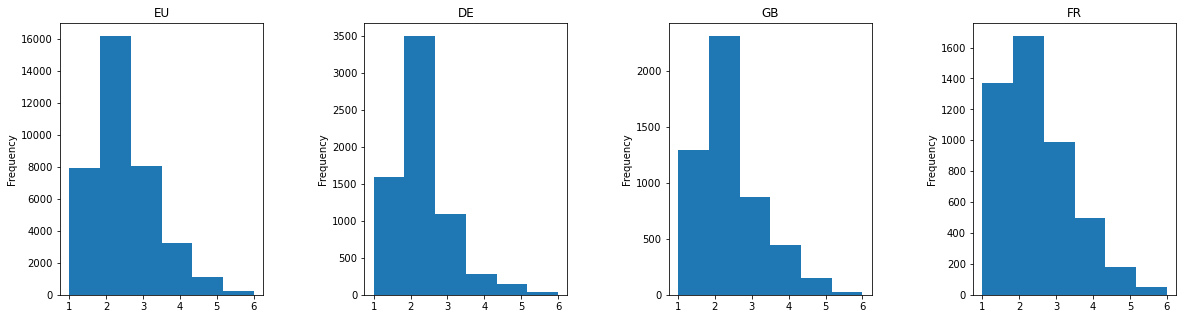

In [9]:
plt.figure(figsize = (20,5))
plt.subplot(1, 4, 1)  # 1 line, 4 rows, index nr 1 (first position in the subplot)
ess_dataset_EU['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU["anweight"], title = 'EU')
plt.subplot(1, 4, 2)  # 1 line, 4 rows, index nr 2 (second position in the subplot)
ess_dataset_DE['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE["anweight"], title = 'DE')
plt.subplot(1, 4, 3)  # 1 line, 4 rows, index nr 3 (third position in the subplot)
ess_dataset_GB['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB["anweight"], title = 'GB')
plt.subplot(1, 4, 4)  # 1 line, 4 rows, index nr 4 (fourth position in the subplot)
ess_dataset_FR['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR["anweight"], title = 'FR')
plt.subplots_adjust(wspace=0.5)
plt.show()

As we can see, most people in Europe, Germany, the UK and France tend to self-identify with the general statement. France is a bit different, respondents' answers are more distributed even though the trend remains the same.


### Looking at sex and gender 
In the table below, I’ve compared people’s attitude towards the same general statement (“It is important to her/him to listen to people who are different from her/him. Even when she/he disagrees with them, she/he still wants to understand them”).

I’ve compared answers based on:
- Gender (see note 1)
- Relationship: living without a partner, with an other-sex or same-sex partner
- A sense of being discriminated against based on sex or gender
- Attitude towards gays and lesbians (see note 2)

*Note 1: The survey offers only two options for gender: male or female.*

*Note 2: For simplicity, I have selected people having the most positive attitude towards gays and lesbians (see appendix).*

*In grey are populations that are too small to make accurate comparisons.*

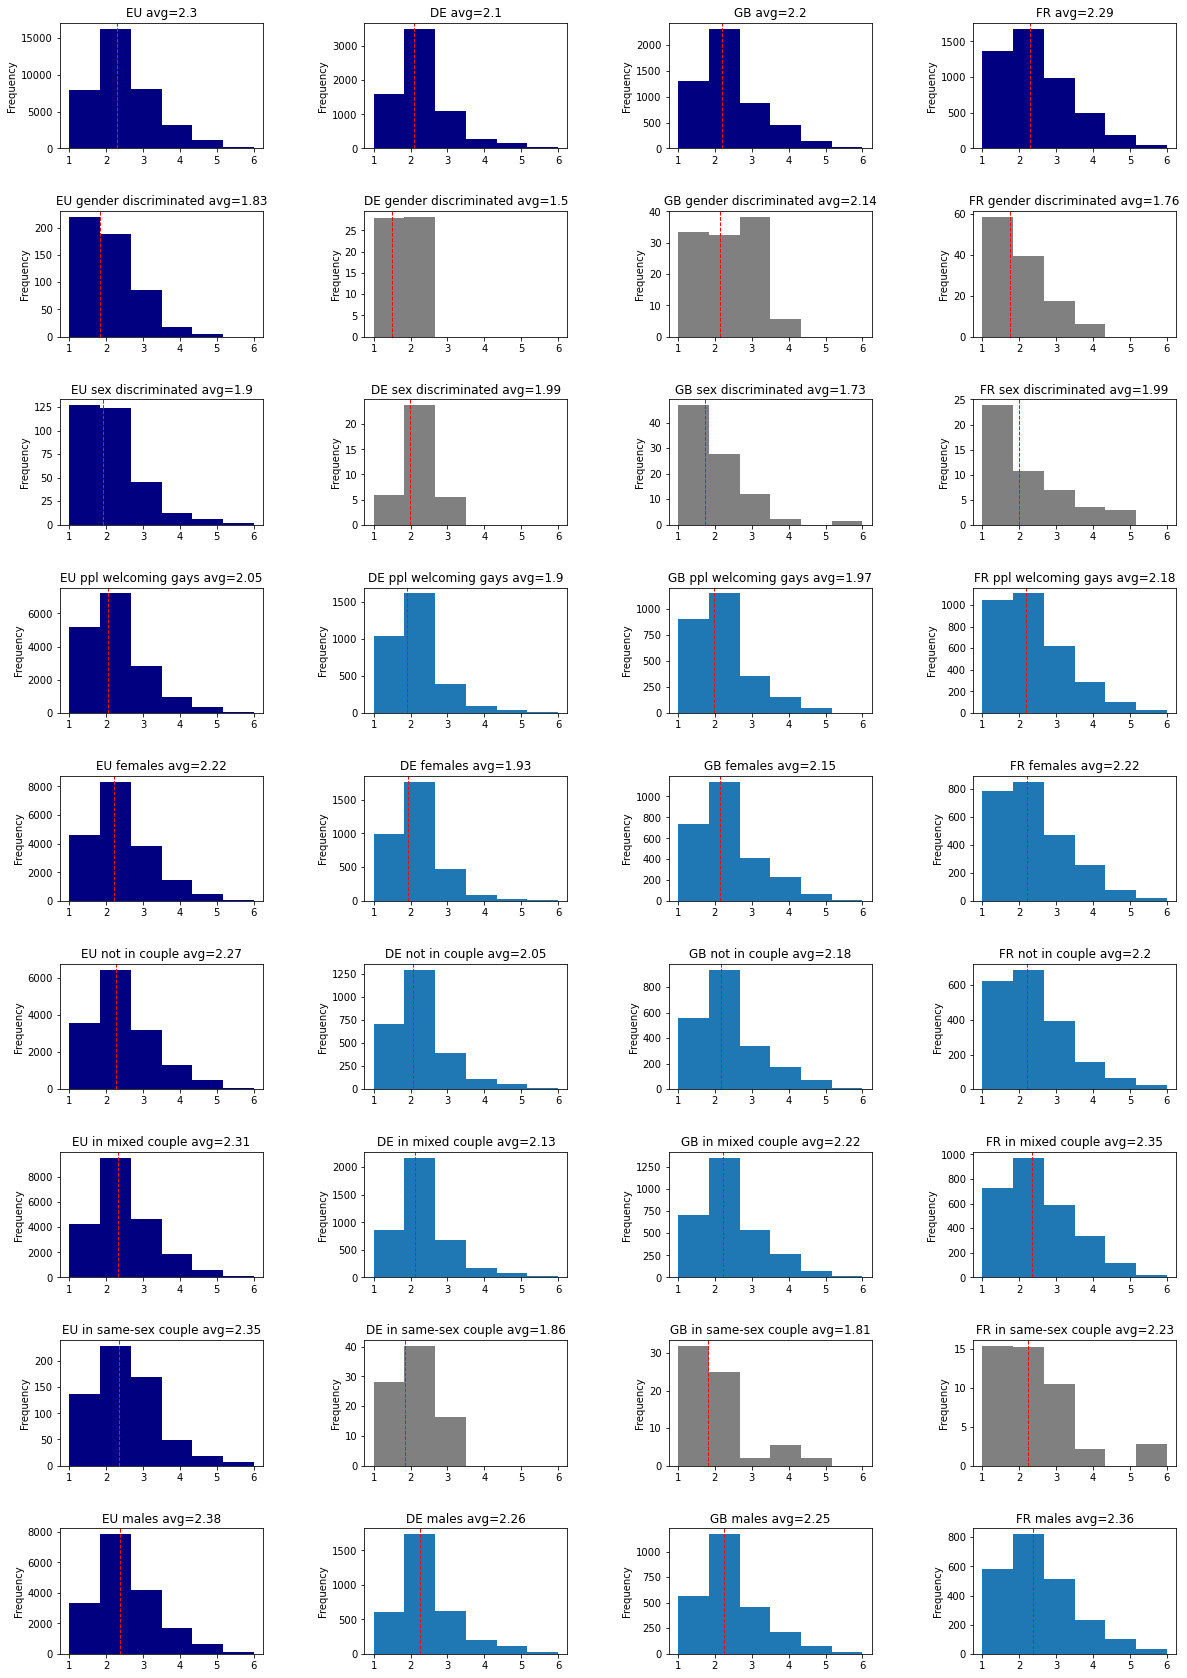

In [10]:
# function to calculate weighted average
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

plt.figure(figsize = (20,30))
plt.subplot(9, 4, 1)  
ess_dataset_EU['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU["anweight"], title = 'EU avg='+round(w_avg(ess_dataset_EU, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 2) 
ess_dataset_DE['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE["anweight"], title = 'DE avg='+round(w_avg(ess_dataset_DE, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_DE, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 3) 
ess_dataset_GB['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB["anweight"], title = 'GB avg='+round(w_avg(ess_dataset_GB, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_GB, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 4) 
ess_dataset_FR['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR["anweight"], title = 'FR avg='+round(w_avg(ess_dataset_FR, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_FR, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 5)  
ess_dataset_EU[ess_dataset_EU['dscrgnd']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['dscrgnd']==1]["anweight"], title = 'EU gender discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrgnd']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrgnd']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 6)  
ess_dataset_DE[ess_dataset_DE['dscrgnd']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['dscrgnd']==1]["anweight"], title = 'DE gender discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrgnd']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrgnd']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 7)  
ess_dataset_GB[ess_dataset_GB['dscrgnd']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['dscrgnd']==1]["anweight"], title = 'GB gender discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrgnd']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrgnd']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 8)  
ess_dataset_FR[ess_dataset_FR['dscrgnd']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['dscrgnd']==1]["anweight"], title = 'FR gender discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrgnd']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrgnd']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 9)  
ess_dataset_EU[ess_dataset_EU['dscrsex']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['dscrsex']==1]["anweight"], title = 'EU sex discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrsex']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrsex']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 10)  
ess_dataset_DE[ess_dataset_DE['dscrsex']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['dscrsex']==1]["anweight"], title = 'DE sex discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrsex']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrsex']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 11)  
ess_dataset_GB[ess_dataset_GB['dscrsex']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['dscrsex']==1]["anweight"], title = 'GB sex discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrsex']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrsex']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 12)  
ess_dataset_FR[ess_dataset_FR['dscrsex']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['dscrsex']==1]["anweight"], title = 'FR sex discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrsex']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrsex']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 13)  
ess_dataset_EU[ess_dataset_EU['freehms']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['freehms']==1]["anweight"], title = 'EU ppl welcoming gays avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['freehms']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['freehms']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 14)  
ess_dataset_DE[ess_dataset_DE['freehms']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['freehms']==1]["anweight"], title = 'DE ppl welcoming gays avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['freehms']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['freehms']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 15)  
ess_dataset_GB[ess_dataset_GB['freehms']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['freehms']==1]["anweight"], title = 'GB ppl welcoming gays avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['freehms']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['freehms']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 16)  
ess_dataset_FR[ess_dataset_FR['freehms']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['freehms']==1]["anweight"], title = 'FR ppl welcoming gays avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['freehms']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['freehms']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 17)  
ess_dataset_EU[ess_dataset_EU['gndr']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['gndr']==2]["anweight"], title = 'EU females avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==2], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 18)  
ess_dataset_DE[ess_dataset_DE['gndr']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['gndr']==2]["anweight"], title = 'DE females avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==2], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 19)  
ess_dataset_GB[ess_dataset_GB['gndr']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['gndr']==2]["anweight"], title = 'GB females avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==2], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 20)  
ess_dataset_FR[ess_dataset_FR['gndr']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['gndr']==2]["anweight"], title = 'FR females avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==2], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 21)  
ess_dataset_EU[ess_dataset_EU['sexori']==0]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['sexori']==0]["anweight"], title = 'EU not in couple avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==0], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==0], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 22)  
ess_dataset_DE[ess_dataset_DE['sexori']==0]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['sexori']==0]["anweight"], title = 'DE not in couple avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==0], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==0], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 23)  
ess_dataset_GB[ess_dataset_GB['sexori']==0]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['sexori']==0]["anweight"], title = 'GB not in couple avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==0], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==0], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 24)  
ess_dataset_FR[ess_dataset_FR['sexori']==0]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['sexori']==0]["anweight"], title = 'FR not in couple avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==0], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==0], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 25)  
ess_dataset_EU[ess_dataset_EU['sexori']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['sexori']==1]["anweight"], title = 'EU in mixed couple avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 26)  
ess_dataset_DE[ess_dataset_DE['sexori']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['sexori']==1]["anweight"], title = 'DE in mixed couple avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 27)  
ess_dataset_GB[ess_dataset_GB['sexori']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['sexori']==1]["anweight"], title = 'GB in mixed couple avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 28)  
ess_dataset_FR[ess_dataset_FR['sexori']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['sexori']==1]["anweight"], title = 'FR in mixed couple avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 29)  
ess_dataset_EU[ess_dataset_EU['sexori']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['sexori']==2]["anweight"], title = 'EU in same-sex couple avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==2], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 30)  
ess_dataset_DE[ess_dataset_DE['sexori']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['sexori']==2]["anweight"], title = 'DE in same-sex couple avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==2], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 31)  
ess_dataset_GB[ess_dataset_GB['sexori']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['sexori']==2]["anweight"], title = 'GB in same-sex couple avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==2], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 32)  
ess_dataset_FR[ess_dataset_FR['sexori']==2]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['sexori']==2]["anweight"], title = 'FR in same-sex couple avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==2], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==2], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 33)  
ess_dataset_EU[ess_dataset_EU['gndr']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['gndr']==1]["anweight"], title = 'EU males avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 34)  
ess_dataset_DE[ess_dataset_DE['gndr']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['gndr']==1]["anweight"], title = 'DE males avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 35)  
ess_dataset_GB[ess_dataset_GB['gndr']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['gndr']==1]["anweight"], title = 'GB males avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 36)  
ess_dataset_FR[ess_dataset_FR['gndr']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['gndr']==1]["anweight"], title = 'FR males avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

Overall, respondents are more likely to embrace difference:
1. When they feel discriminated against because of their sex or gender
2. When they believe that "gay men and lesbians should be free to live their own life as they wish"
3. When they identify as being a woman 
4. When they don’t live with a partner 

The order differs slightly per country, but embracing difference is by far most correlated with gender and sexual discrimination. Those most affected by lack of pluralism believe the most strongly in the benefits of diversity, it seems. This probably also explains why European women tend to embrace diversity more than men, but it is only an assumption.

People feeling sympathy for gay men and lesbians are consistent in their beliefs and are more likely to be pluralists.

This also applies to same-sex couples in Germany and the UK. Surprisingly, it doesn’t apply in France. Furthermore, europeans not living with a partner embrace difference more than those living with a same-sex partner. This might be due to the relatively small number of respondents in the second category. Another explanation could be that same-sex couples have a more conservative lifestyle than singles (more explanations are welcomed!). 


### Cross Checking with attitude towards race and ethnicity 
Results above seem to indicate that discrimination based on gender and sexual orientation makes affected people more appreciative of diversity.

To verify this, I’m going to compare their response to the following question: “To what extent do you think [country] should allow people of a different race or ethnic group from most [country] people?”

(1 = allow many to come and live here, 4 - allow none)

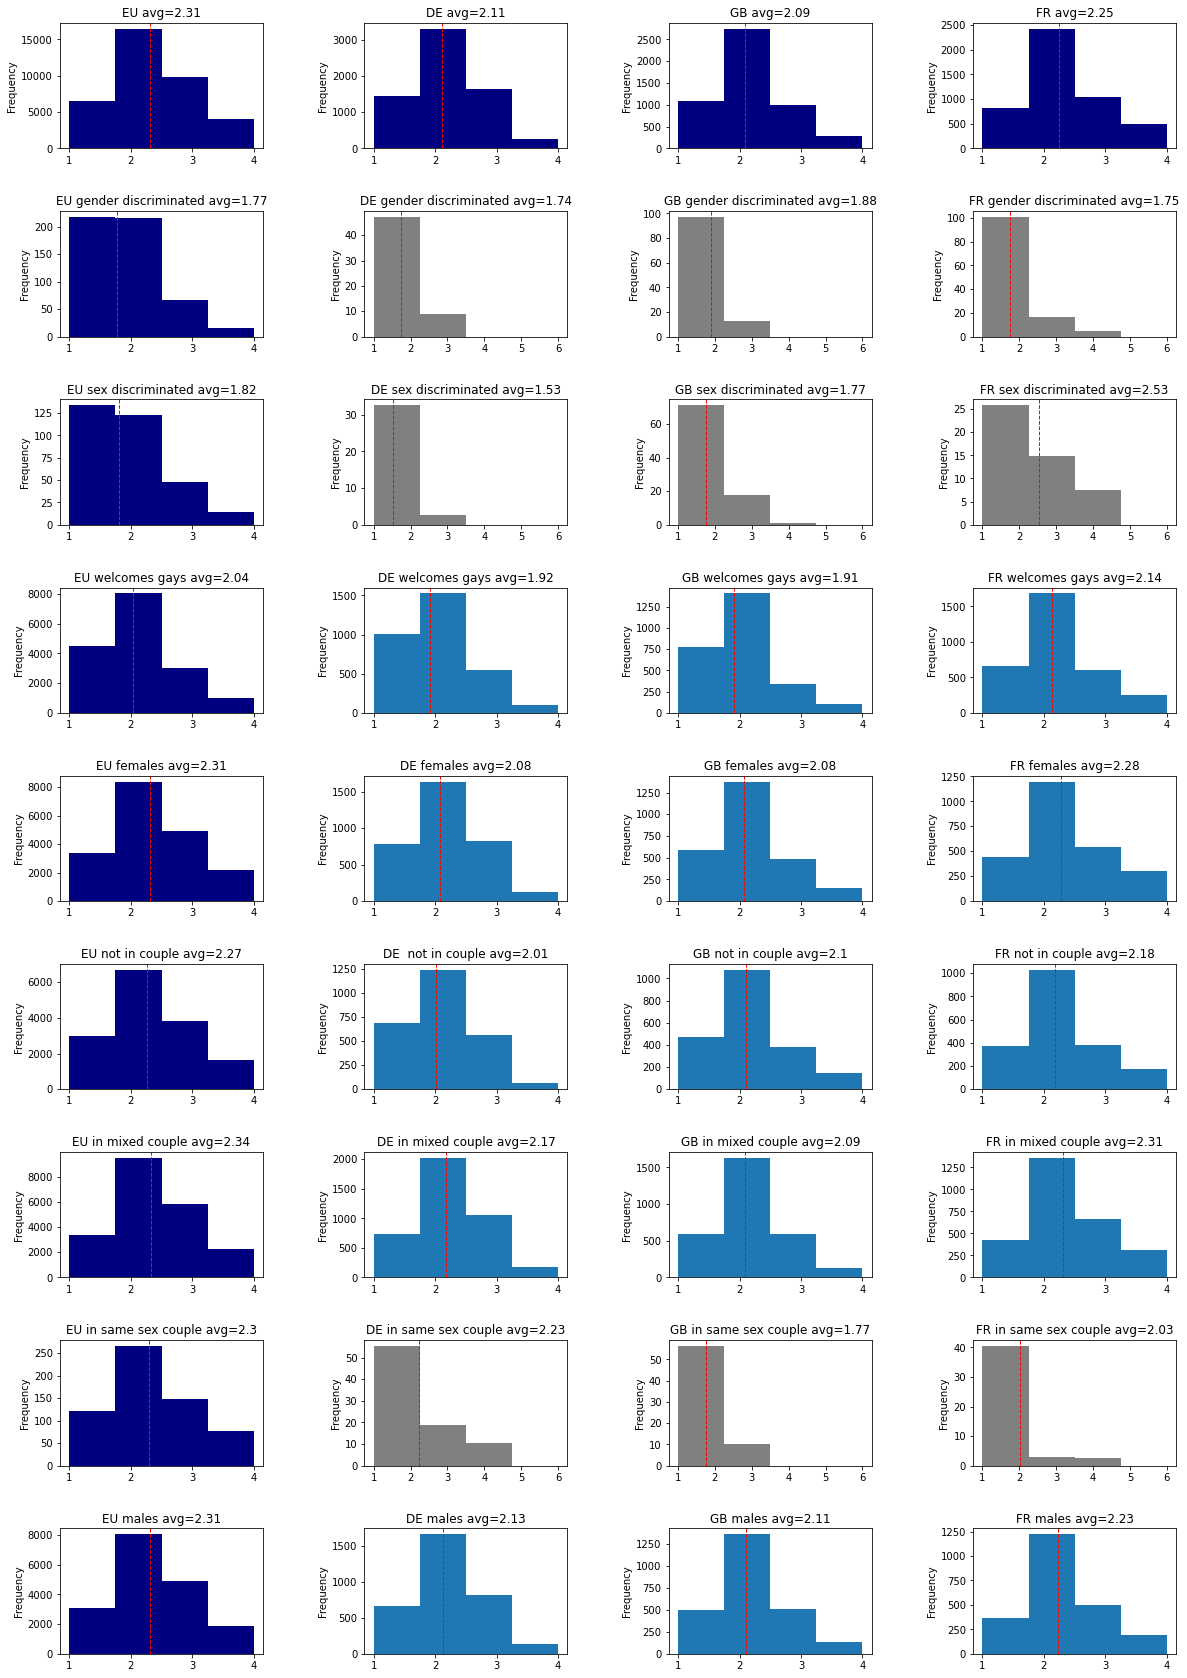

In [11]:
plt.figure(figsize = (20,30))
plt.subplot(9, 4, 1)  
ess_dataset_EU['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU["anweight"], title = 'EU avg='+round(w_avg(ess_dataset_EU, 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU, 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 2) 
ess_dataset_DE['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE["anweight"], title = 'DE avg='+round(w_avg(ess_dataset_DE, 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_DE, 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 3) 
ess_dataset_GB['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB["anweight"], title = 'GB avg='+round(w_avg(ess_dataset_GB, 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_GB, 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 4) 
ess_dataset_FR['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR["anweight"], title = 'FR avg='+round(w_avg(ess_dataset_FR, 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_FR, 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 5)  
ess_dataset_EU[ess_dataset_EU['dscrgnd']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['dscrgnd']==1]["anweight"], title = 'EU gender discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrgnd']==1], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrgnd']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 6)  
ess_dataset_DE[ess_dataset_DE['dscrgnd']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['dscrgnd']==1]["anweight"], title = 'DE gender discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrgnd']==1], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrgnd']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 7)  
ess_dataset_GB[ess_dataset_GB['dscrgnd']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['dscrgnd']==1]["anweight"], title = 'GB gender discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrgnd']==1], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrgnd']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 8)  
ess_dataset_FR[ess_dataset_FR['dscrgnd']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['dscrgnd']==1]["anweight"], title = 'FR gender discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrgnd']==1], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrgnd']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 9)  
ess_dataset_EU[ess_dataset_EU['dscrsex']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['dscrsex']==1]["anweight"], title = 'EU sex discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrsex']==1], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrsex']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 10)  
ess_dataset_DE[ess_dataset_DE['dscrsex']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['dscrsex']==1]["anweight"], title = 'DE sex discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrsex']==1], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrsex']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 11)  
ess_dataset_GB[ess_dataset_GB['dscrsex']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['dscrsex']==1]["anweight"], title = 'GB sex discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrsex']==1], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrsex']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 12)  
ess_dataset_FR[ess_dataset_FR['dscrsex']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['dscrsex']==1]["anweight"], title = 'FR sex discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrsex']==1], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrsex']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 13)  
ess_dataset_EU[ess_dataset_EU['freehms']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['freehms']==1]["anweight"], title = 'EU welcomes gays avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['freehms']==1], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['freehms']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 14)  
ess_dataset_DE[ess_dataset_DE['freehms']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['freehms']==1]["anweight"], title = 'DE welcomes gays avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['freehms']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['freehms']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 15)  
ess_dataset_GB[ess_dataset_GB['freehms']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['freehms']==1]["anweight"], title = 'GB welcomes gays avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['freehms']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['freehms']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 16)  
ess_dataset_FR[ess_dataset_FR['freehms']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['freehms']==1]["anweight"], title = 'FR welcomes gays avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['freehms']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['freehms']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 17)  
ess_dataset_EU[ess_dataset_EU['gndr']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['gndr']==2]["anweight"], title = 'EU females avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==2], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 18)  
ess_dataset_DE[ess_dataset_DE['gndr']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['gndr']==2]["anweight"], title = 'DE females avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==2], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 19)  
ess_dataset_GB[ess_dataset_GB['gndr']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['gndr']==2]["anweight"], title = 'GB females avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==2], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 20)  
ess_dataset_FR[ess_dataset_FR['gndr']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['gndr']==2]["anweight"], title = 'FR females avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==2], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 21)  
ess_dataset_EU[ess_dataset_EU['sexori']==0]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['sexori']==0]["anweight"], title = 'EU not in couple avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==0], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==0], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 22)  
ess_dataset_DE[ess_dataset_DE['sexori']==0]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['sexori']==0]["anweight"], title = 'DE  not in couple avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==0], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==0], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 23)  
ess_dataset_GB[ess_dataset_GB['sexori']==0]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['sexori']==0]["anweight"], title = 'GB not in couple avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==0], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==0], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 24)  
ess_dataset_FR[ess_dataset_FR['sexori']==0]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['sexori']==0]["anweight"], title = 'FR not in couple avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==0], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==0], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 25)  
ess_dataset_EU[ess_dataset_EU['sexori']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['sexori']==1]["anweight"], title = 'EU in mixed couple avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==1], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 26)  
ess_dataset_DE[ess_dataset_DE['sexori']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['sexori']==1]["anweight"], title = 'DE in mixed couple avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 27)  
ess_dataset_GB[ess_dataset_GB['sexori']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['sexori']==1]["anweight"], title = 'GB in mixed couple avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 28)  
ess_dataset_FR[ess_dataset_FR['sexori']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['sexori']==1]["anweight"], title = 'FR in mixed couple avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 29)  
ess_dataset_EU[ess_dataset_EU['sexori']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['sexori']==2]["anweight"], title = 'EU in same sex couple avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==2], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['sexori']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 30)  
ess_dataset_DE[ess_dataset_DE['sexori']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['sexori']==2]["anweight"], title = 'DE in same sex couple avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==2], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['sexori']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 31)  
ess_dataset_GB[ess_dataset_GB['sexori']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['sexori']==2]["anweight"], title = 'GB in same sex couple avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==2], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['sexori']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 32)  
ess_dataset_FR[ess_dataset_FR['sexori']==2]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['sexori']==2]["anweight"], title = 'FR in same sex couple avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==2], 'imdfetn', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['sexori']==2], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 33)  
ess_dataset_EU[ess_dataset_EU['gndr']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_EU[ess_dataset_EU['gndr']==1]["anweight"], title = 'EU males avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==1], 'imdfetn', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['gndr']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 34)  
ess_dataset_DE[ess_dataset_DE['gndr']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_DE[ess_dataset_DE['gndr']==1]["anweight"], title = 'DE males avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['gndr']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 35)  
ess_dataset_GB[ess_dataset_GB['gndr']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_GB[ess_dataset_GB['gndr']==1]["anweight"], title = 'GB males avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['gndr']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 36)  
ess_dataset_FR[ess_dataset_FR['gndr']==1]['imdfetn'].plot.hist(bins=4,weights=ess_dataset_FR[ess_dataset_FR['gndr']==1]["anweight"], title = 'FR males avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==1], 'imdfetn', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['gndr']==1], 'imdfetn', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

People discriminated against based on sex or gender do also tend to be more welcoming to immigrants from other races and ethnicities. This is validating the point I was making in the previous section.

It is also the case for people feeling sympathy for gay men and lesbians. They remain consistent in their appreciation of diversity.

It is not systematically the case for women and singles who, on average, have feelings towards different races and ethnicities that are closer to averages. 

It would be wrong to draw too many conclusions from what is a simple exploration. But what is clear is that the feeling of being discriminated against has a much bigger impact on attitude towards diversity than belonging to any gender or sexual orientation group.

Is this a good or bad thing? On the one hand, it is rational and perfectly understandable to value diversity more if we are ourselves being discriminated against. On the other hand, would it not be better if people felt equally passionate about diversity whether they are discriminated against or not? 

It is the same perpetual debate as for any other human value: is it right if only disadvantaged communities feel passionate about equality ? For civil servants to always defend public service and for business people to always defend free competition ? Are self-serving human values ok? Or should we all think bigger?

What makes these questions even more problematic is that pluralism is all about embracing diversity. Can people be considered true pluralists if their belief is only serving their own interests? 


### Next part: Race and Ethniciy
**In the next part of my exploration, I will be looking at the relation between pluralism, race and ethnicity.**

[Pluralism in Europe - Part 3: Race and Ethnicity](3_Pluralism_Race&Ethnicity.ipynb)

### Appendix: Attitude towards gay men and lesbians 
 

As noted in the main results, I have selected people having only the most positive attitude towards gay men and lesbians to study the impact their sympathy has on embracing diversity.

Here is a more detailed analysis performed at the European level and without using design weights.

Each diagram shows how respondents feel about "gay men and lesbians being free to live their own life as they wish" (1 = agree strongly, 5 = disagree strongly).

In colour are proportions of respondents believing "it is important to listen to people who are different from them" (1 = very much like me, 6 = not like me at all).

On the right are the same results but normalised. 


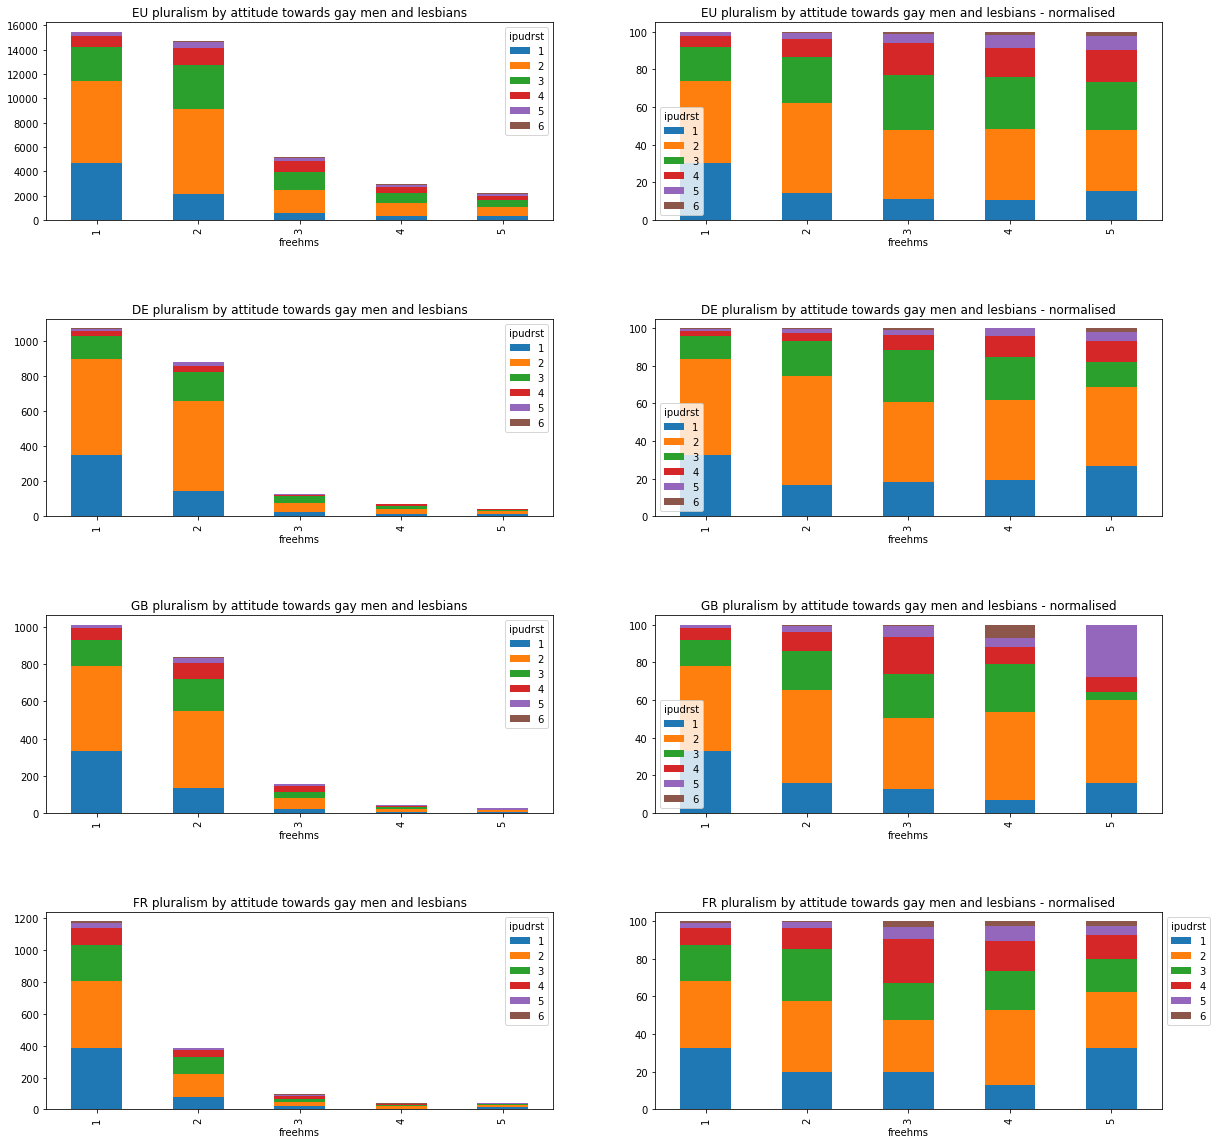

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=2)

stacked_data = ess_dataset_EU.groupby(['freehms', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[0,0],figsize = (20,20), title='EU pluralism by attitude towards gay men and lesbians')
stacked_data = ess_dataset_EU.groupby(['freehms', 'ipudrst']).agg('size').unstack().apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[0,1], title='EU pluralism by attitude towards gay men and lesbians - normalised')

stacked_data = ess_dataset_DE.groupby(['freehms', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[1,0], title='DE pluralism by attitude towards gay men and lesbians')
stacked_data = ess_dataset_DE.groupby(['freehms', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[1,1], title='DE pluralism by attitude towards gay men and lesbians - normalised')

stacked_data = ess_dataset_GB.groupby(['freehms', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[2,0], title='GB pluralism by attitude towards gay men and lesbians')
stacked_data = ess_dataset_GB.groupby(['freehms', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[2,1], title='GB pluralism by attitude towards gay men and lesbians - normalised')

stacked_data = ess_dataset_FR.groupby(['freehms', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[3,0], title='FR pluralism by attitude towards gay men and lesbians')
stacked_data = ess_dataset_FR.groupby(['freehms', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[3,1], title='FR pluralism by attitude towards gay men and lesbians - normalised')

plt.subplots_adjust(hspace=0.5)
plt.legend(bbox_to_anchor=(1.0, 1.0),title='ipudrst')

We can see that stronger attitudes towards gay men and lesbians come with stronger attitudes towards difference, which is to be expected. What is surprising is that those strongly against gay freedom also feel strongly about their ability to listen people different than them (anyone has an explanation?).

Overall, people who strongly believe that "gay men and lesbians should be free to live their own life as they wish" have the most characteristic attitude towards diversity, this is why I have used this category in my main analysis. 